# Esperienza Microonde

### Utility per propagazione errore

L'angolo del goniometro era sfasato, tenerne conto nella relazione

In [2]:
import sympy
import numpy as np

def value_and_covariance_gen(expr, variables):
    expr = sympy.parse_expr(expr)

    symbols = sympy.symbols(variables)
    cov_symbols = sympy.symbols(tuple("C_" + k for k in variables))
    expr2 = sum(expr.diff(s) ** 2 * c for s, c in zip(symbols, cov_symbols))
    expr2 = expr2.simplify() # recommended for speed and accuracy

    fval = sympy.lambdify(symbols, expr)
    fcov = sympy.lambdify(symbols + cov_symbols, expr2)

    def fn(**kwargs):
        x = tuple(v[0] for v in kwargs.values())
        c = tuple(v[1] for v in kwargs.values())
        return fval(*x), fcov(*x, *c)

    return fn


def value_and_covariance(expr, **kwargs):
    return value_and_covariance_gen(expr, tuple(kwargs))(**kwargs)

## Caratterizzazione del fascio

### Legge di Malus / Polarizzazione

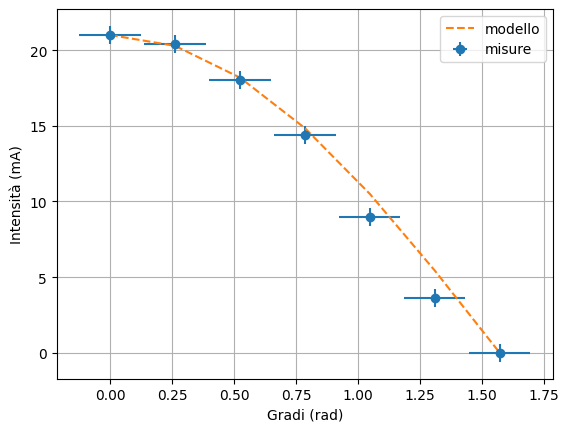

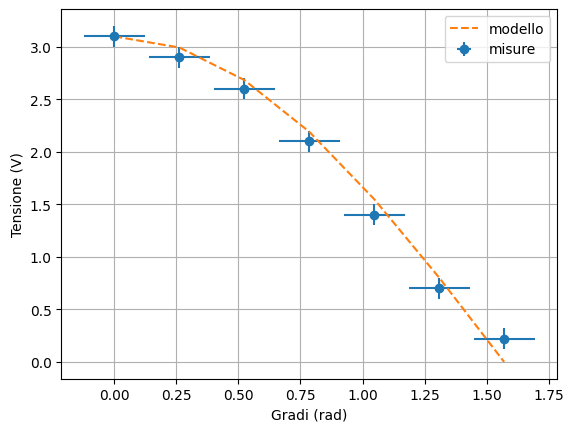

In [3]:
import numpy as np

theta = [0, 15, 30, 45, 60, 75, 90]
err_theta = 5 # gradi per un singoo ricervitore/trasmittore
err_totale = np.radians(np.sqrt(5**2+5**2))

# amperaggio mA x 30
M = [0.7, 0.68, 0.6, 0.48, 0.3, 0.12, 0] # * 30
err_M = .02 * 30
# voltmetro
V = [3.1, 2.9, 2.6, 2.1, 1.4, 0.7, 0.22]
err_V = [0.1, 0.01, 0.01, 0.01, 0.01, 0.01]

# plot data of cos(theta) with M and V
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Gradi (rad)")
ax.set_ylabel("Intensità (mA)")

#plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=err_totale, fmt='o', label='misure')
# plot M[0]*30 * cos(theta)
plt.plot(np.radians(theta), M[0]*30 * np.cos(np.radians(theta)), '--', label='modello')

plt.grid()
plt.legend()
plt.show()


fig,ax = plt.subplots(1,1)
ax.set_xlabel("Gradi (rad)")
ax.set_ylabel("Tensione (V)")

# plot data of cos(theta) with V
#plt.plot(np.radians(theta), V, 'o--')
plt.errorbar(np.radians(theta), V, yerr=0.1, xerr=err_totale, fmt='o',label='misure')
# plot V[0] * cos(theta)
plt.plot(np.radians(theta), V[0] * np.cos(np.radians(theta)), '--', label='modello')

plt.grid()
plt.legend()
plt.show()

### Ampiezza

1. Studiare dipendenza ampiezza dall'angolo
2. Studiare dipendenza ampiezza dalla distanza

<ErrorbarContainer object of 3 artists>

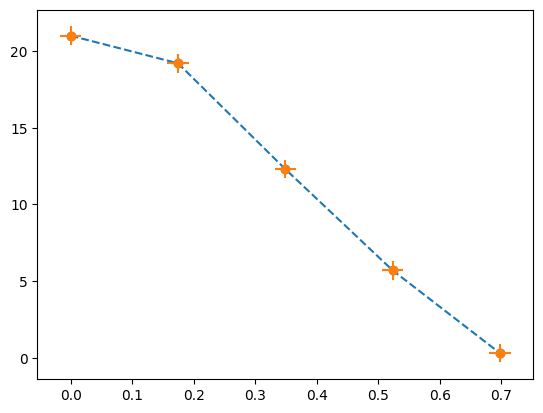

In [4]:
r_i = 101.7 # cm

# Punto 1
theta = [0, 10, 20, 30, 40]
M = [0.7, 0.64, 0.41, 0.19, 0.01] #x30

plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=np.radians(1), fmt='o')

In [5]:
# confronto fit 1/r, 1/r^2
import iminuit as m
from iminuit import Minuit
from iminuit.cost import LeastSquares

# misura delle distanze fatte considerando ogni lunghezza d'onda per avere gli stessi massimi

lambda_ = 2.85 # cm

# misura amperometro
d_max = (81 - 12.5 - lambda_   * np.array([1, 2, 3, 4, 5, 6, 7, 8])) * 0.01
d_min = (81 - 12.5 - lambda_/2 * np.array([1, 3, 5, 7, 9, 11, 13, 15])) * 0.01
err_d = 0.005
M_max = np.array([0.56, 0.6, 0.64, 0.66, 0.7, 0.72, 0.76, 0.82]) * 30
M_min = np.array([0.56, 0.58, 0.6, 0.64, 0.68, 0.7, 0.72, 0.78]) * 30
err_M = 0.02 * 30
# trasform err_M in vector with 8 same vlaues
err_M = np.array([err_M] * 8)

V_max = np.array([2.4, 2.6, 2.8, 2.9, 3.1, 3.2, 3.3, 3.7])
V_min = np.array([2.4, 2.5, 2.6, 2.8, 3, 3.1, 3.2, 3.5])
err_V = 0.1

def model(x, a):
    return a/x

minimi_quadrati = LeastSquares(d_max, M_max, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
#m.visualize()

a1 = m.values["a"]
err_a1 = m.errors["a"]

minimi_quadrati = LeastSquares(d_min, M_min, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
# m.visualize()


a2 = m.values["a"]
err_a2 = m.errors["a"]

minimi_quadrati = LeastSquares(d_min, V_min, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)

a3 = m.values["a"]
err_a3 = m.errors["a"]

minimi_quadrati = LeastSquares(d_max, V_max, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)

a4 = m.values["a"]
err_a4 = m.errors["a"]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.678 (χ²/ndof = 0.2)      │              Nfcn = 20               │
│ EDM = 2.68e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   11.24   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      a │
├───┼────────┤
│ a │ 0.0134 │
└───┴────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.084 (χ²/ndof = 0.3)      │              Nfcn = 20               │
│ EDM = 7.41e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   11.10   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      a │
├───┼────────┤
│ a │ 0.0141 │
└───┴────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.651 (χ²/ndof = 0.2)      │              Nfcn = 20               │
│ EDM = 2.17e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.628   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000392 │
└───┴──────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.717 (χ²/ndof = 0.5)      │              Nfcn = 20               │
│ EDM = 3.57e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.649   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000371 │
└───┴──────────┘

Mostriamo che il modello $\frac{a}{x^2}$ non può essere giusto oltre a mostrare come $\frac{a}{r}$ funzioni

In [6]:
def model(x, a):
    return a/(x**2)

minimi_quadrati = LeastSquares(d_max, M_max, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
#m.visualize()

minimi_quadrati = LeastSquares(d_min, M_min, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
# m.visualize()


minimi_quadrati = LeastSquares(d_min, V_min, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)


minimi_quadrati = LeastSquares(d_max, V_max, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.9 (χ²/ndof = 19.6)     │              Nfcn = 18               │
│ EDM = 5.51e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   5.91    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       a │
├───┼─────────┤
│ a │ 0.00376 │
└───┴─────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 132.1 (χ²/ndof = 18.9)     │              Nfcn = 18               │
│ EDM = 5.57e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   6.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       a │
├───┼─────────┤
│ a │ 0.00419 │
└───┴─────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 80.14 (χ²/ndof = 11.4)     │              Nfcn = 18               │
│ EDM = 3.99e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.882   │   0.011   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000116 │
└───┴──────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 89.72 (χ²/ndof = 12.8)     │              Nfcn = 16               │
│ EDM = 6.31e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.869   │   0.010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000104 │
└───┴──────────┘

### Grafici
Intensità massimi

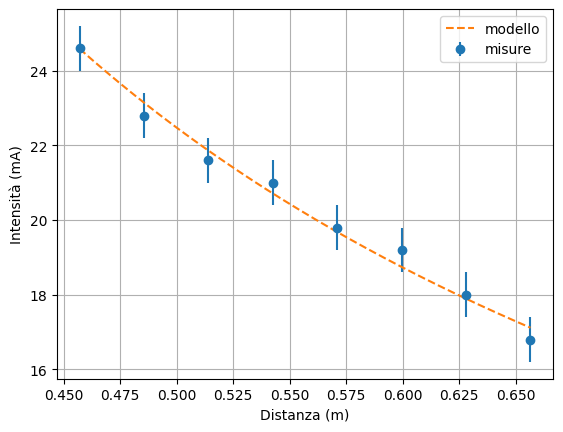

In [7]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Distanza (m)")
ax.set_ylabel("Intensità (mA)")

x = np.linspace(d_max.min(), d_max.max(), 1000)
y = a1 / x

ax.errorbar(d_max,M_max,err_M,fmt='o',label='misure')
ax.plot(x,y,linestyle='--',label='modello')

ax.grid()
ax.legend()
plt.show()

Intensità minimi

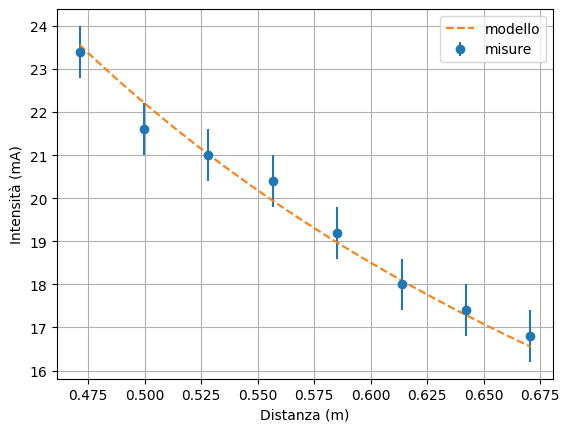

In [8]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Distanza (m)")
ax.set_ylabel("Intensità (mA)")

x = np.linspace(d_min.min(), d_min.max(), 1000)
y = a2 / x

ax.errorbar(d_min,M_min,err_M,fmt='o',label='misure')
ax.plot(x,y,linestyle='--',label='modello')

ax.grid()
ax.legend()
plt.show()

Tensione massimi

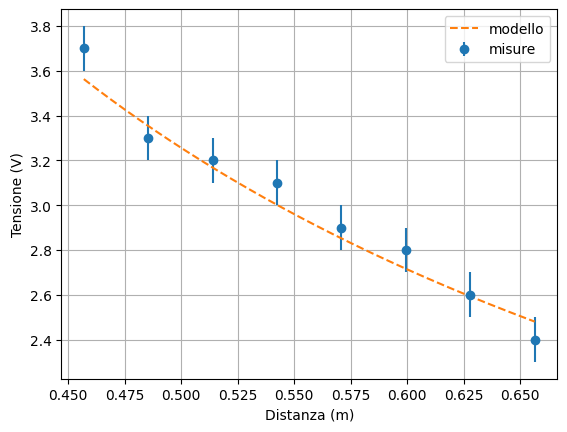

In [9]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Distanza (m)")
ax.set_ylabel("Tensione (V)")

x = np.linspace(d_max.min(), d_max.max(), 1000)
y = a3 / x

ax.errorbar(d_max,V_max,err_V,fmt='o',label='misure')
ax.plot(x,y,linestyle='--',label='modello')

ax.grid()
ax.legend()
plt.show()

Tensione minimi

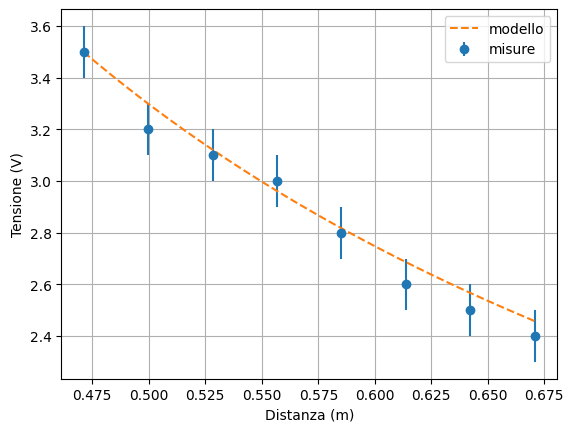

In [10]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Distanza (m)")
ax.set_ylabel("Tensione (V)")

x = np.linspace(d_min.min(), d_min.max(), 1000)
y = a4 / x

ax.errorbar(d_min,V_min,err_V,fmt='o',label='misure')
ax.plot(x,y,linestyle='--',label='modello')

ax.grid()
ax.legend()
plt.show()

### Geometria

In [11]:
# parliamo pure della orientazione della polarizzazione
# verticale per avere valore minimo di amperaggio

## Angolo di Brewster

In [12]:
def model(x, a):
    return a*x**2

theta = np.radians([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 47, 57, 23, \
                    27, 33, 37, 43, 53, 63])
M = np.array([0.50, 0.52, 0.56, 0.6, 0.66, 0.67, 0.7, 0.62, 0.48, 0.42, \
              0.680, 0.6, 0.52, 0.54, 0.6, 0.62, 0.68, 0.68, 0.44]) * 30
V = np.array([2.2, 2.3, 2.5, 2.7, 2.9, 3, 3.1, 2.7, 2.1, 1.9, 3.0, 2.6, \
              2.3, 2.4, 2.6, 2.8, 3, 3, 1.9])

sorted_indices = sorted(range(len(theta)), key=lambda i: theta[i])

theta = np.array(theta)[sorted_indices]
M = M[sorted_indices]
V = V[sorted_indices]

err_M = 0.02 * 30
err_M = np.array([err_M] * len(M))

def model(x, a, b, c):
    return c + b*x + a * x**2

minimi_quadrati = LeastSquares(theta[2:16], M[2:16], err_M[2:16], model)

m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()
angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)

minimi_quadrati = LeastSquares(theta[2:16], V[2:16], 0.1, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)
m.migrad()
m.hesse()
display(m)

angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.11 (χ²/ndof = 1.1)      │              Nfcn = 84               │
│ EDM = 1.94e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -38    │     6     │            │            │         │         │       │
│ 1 │ b    │    61     │     8     │            │            │         │         │       │
│ 2 │ c    │   -4.5    │    2.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────┐
│   │    a    b    c │
├───┼────────────────┤
│ a │ 34.5  -49   17 │
│ b │  -49 71.8  -25 │
│ c │   17  -25 8.53 │
└───┴────────────────┘

0.803075506740323 46.012837166550405
11.0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.28 (χ²/ndof = 0.9)      │              Nfcn = 86               │
│ EDM = 2.75e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -6.1    │    1.0    │            │            │         │         │       │
│ 1 │ b    │    9.7    │    1.4    │            │            │         │         │       │
│ 2 │ c    │   -0.8    │    0.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │     a     b     c │
├───┼───────────────────┤
│ a │ 0.965  -1.4  0.47 │
│ b │  -1.4  2.01 -0.69 │
│ c │  0.47 -0.69 0.239 │
└───┴───────────────────┘

0.7900355058587822 45.26570015119125
11.0


<Figure size 640x480 with 0 Axes>

## Interferenza

Studiare almeno due casi (per la valutazione ne vengono utilizzati due)

#### Fabry-Perot


Emettitore e ricevitore verticali

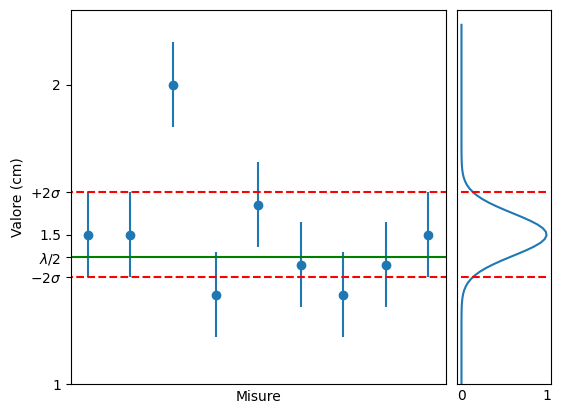

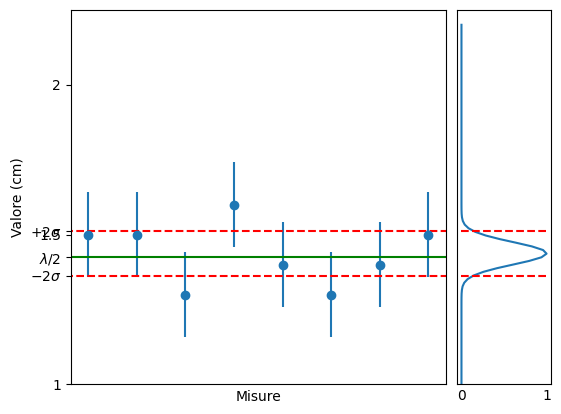

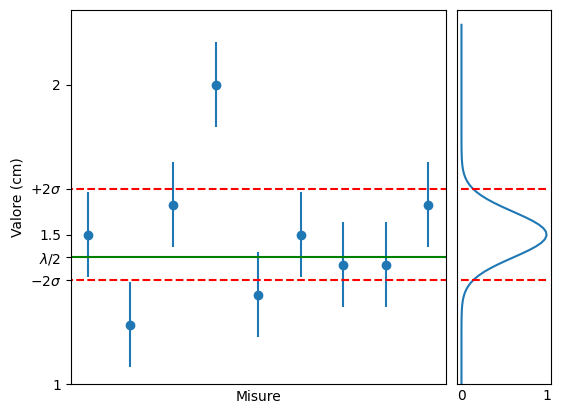

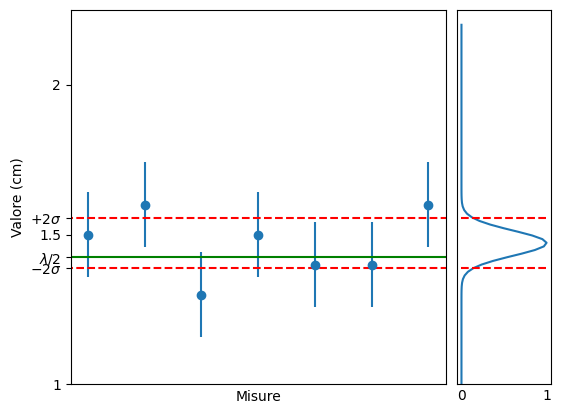

In [13]:
d_fissa = 80 #cm, non serve aumenta l'errore

#errore sistematico spessore lastre si cancella
d_min = np.array([24, 25.5, 27, 29, 30.3, 31.9, 33.3, 34.6, 36, 37.5]) #cm
d_max = np.array([23.5, 25, 26.2, 27.8, 29.8, 31.1, 32.6, 34, 35.4, 37]) #cm
err_d = 0.1 * np.sqrt(2) #cm

# create a vector difference of values between d_min[n+1] - d_min[n]
delta_d_min = np.diff(d_min)
# create a vector difference of values between d_max[n+1] - d_max[n]
delta_d_max = np.diff(d_max)

# rewrite all in a function
def plot_meas_with_gauss(delta_d, err_d, mean, std):
    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    
    ax = fig.add_subplot(gs[1, 0])
    ax_ploty = fig.add_subplot(gs[1, 1], sharey=ax)

    lower_bound = mean-2*std
    upper_bound = mean+2*std
 
    ax.set_xticks([])
    ax.set_xlabel("Misure")
    ax.set_ylabel("Valore (cm)")

    ax.errorbar(range(len(delta_d)), delta_d, yerr=err_d, fmt='o')
    ax.axhline(1.425,0,8, color='green')
    ax.set_yticks([1, lower_bound, 1.425, 1.5, upper_bound, 2])
    ax.set_yticklabels(["1", "$-2\\sigma$", "$\\lambda/2$", "1.5", "$+2\\sigma$", "2"])
    
    ax.axhline(lower_bound, -1, 10, color='r', linestyle="--")
    ax.axhline(upper_bound, -1, 10, color='r', linestyle="--")  
    ax.plot()

    x = np.linspace(1, 2.2, 100)
    ax_ploty.plot(np.exp(-0.5*((x-mean)/std)**2), x)
    ax_ploty.set_ylim(1, 2.25)
    ax_ploty.hlines([lower_bound, upper_bound], 0, 1, color='r', linestyles="dashed")
    ax_ploty.tick_params(labelleft=False, length=0)
    ax_ploty.plot()

mean_min = np.mean(delta_d_min)
std_min = np.std(delta_d_min, ddof=1)/np.sqrt(len(delta_d_min))
plot_meas_with_gauss(delta_d_min, err_d, mean_min, std_min)

delta_d_min = np.delete(delta_d_min, 2)
mean_min = np.mean(delta_d_min)
std_min = np.std(delta_d_min, ddof=1)/np.sqrt(len(delta_d_min))
plot_meas_with_gauss(delta_d_min, err_d, mean_min, std_min)

mean_max = np.mean(delta_d_max)
std_max = np.std(delta_d_max, ddof=1)/np.sqrt(len(delta_d_max))
plot_meas_with_gauss(delta_d_max, err_d, mean_max, std_max)

delta_d_max = np.delete(delta_d_max, 1)
delta_d_max = np.delete(delta_d_max, 2)
mean_max = np.mean(delta_d_max)
std_max = np.std(delta_d_max, ddof=1)/np.sqrt(len(delta_d_max))
plot_meas_with_gauss(delta_d_max, err_d, mean_max, std_max)

#### Doppia fenditura

Emettitore e ricevitore verticali

In [14]:
theta_min = np.radians([8, 17, 27, 40])
theta_max = np.radians([0, 13, 22, 30, ])#45])
err_theta = np.radians(1)

M_max = np.array([0.18, 0.12, 0.12, 0.1,])*30 #0.2]) * 30
M_min = np.array([0.01, 0, 0, 0]) * 30
err_M = 0.02 * 30
V_max = np.array([.8, .6, .6, .4, .8])
err_V = 0.01

d = 17 # cm
err_d = 0.2

lambda_ = 2.85 # cm

print("$\\theta_max$")
display(value_and_covariance("a * sin(t) / 2.85", a=(d, err_d), t=(theta_max, err_theta)))

print("$\\theta_min$")
display(value_and_covariance("(2 * a * sin(t) / 2.85 - 1) / 2", a =(d, err_d), t=(theta_min, err_theta)))

$\theta_max$


(array([0.        , 1.34181331, 2.23449547, 2.98245614]),
 array([0.62099126, 0.59081325, 0.53730284, 0.47189919]))

$\theta_min$


(array([0.33015534, 1.24397157, 2.20801351, 3.33417171]),
 array([0.60944012, 0.57001298, 0.49807536, 0.37458625]))

## Diffrazione di Bragg

$\theta = 0$ è massimo banale per n = 0

### Unione di tutte le misure
Ogni singola misura è poi separata sotto

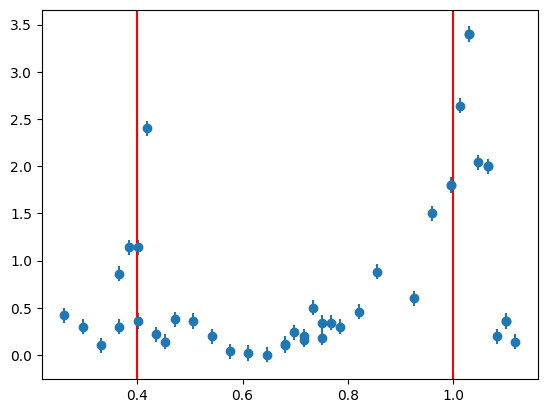

In [15]:
theta = np.array(np.radians([39, 40, 41, 42, 43, 44, 21, 22, 23, 24, 26, 15,17,19,21,23,25,27,29, \
                             31,33,35,37,39,41,43,45,47,49,53,55,57,59,61,63, 57, 58, 59, 60, 61, 62, 63, 64]))

M = np.array([0.12, 0.24, 0.16, 0.5, 0.34, 0.34, 0.3, 0.38*3, 0.38*3, 0.8*3, 0.14, 0.42, 0.3, 0.1, 0.86, 0.36, 0.22, 0.38, 0.36, 0.2, \
            0.04, 0.02, 0, 0.1, 0.2, 0.18, 0.3, 0.46, 0.88, 0.60, 1.5, 1.8, 3.4, 2.0, 0.36, \
            1.8, 2.64, 3.4, 2.04, 2.0,  0.2, 0.36, 0.14])

err_M = np.array( [0.08] * len(M) )

plt.errorbar(theta, M, err_M, fmt='o')
plt.axvline(0.4,0,1,color='r')
plt.axvline(1,0,1,color='r')
plt.show()

Godo, ho trovato come mettere i theta in ordine, ma rimanendo nella stessa posizione con M :)

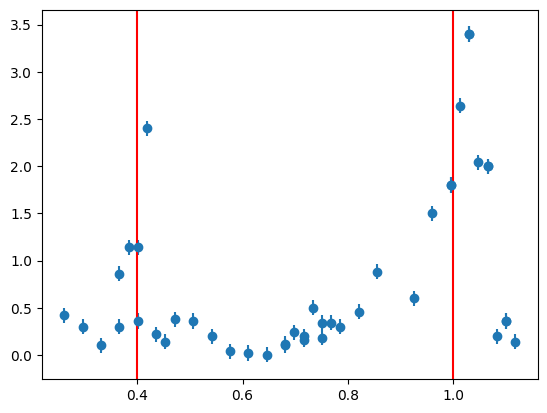

In [16]:
theta_sorted, M_sorted = zip(*sorted(zip(theta, M)))

plt.errorbar(theta_sorted, M_sorted, err_M, fmt='o')
plt.axvline(0.4,0,1,color='r')
plt.axvline(1,0,1,color='r')
plt.show()

### Ricerca dei massimi

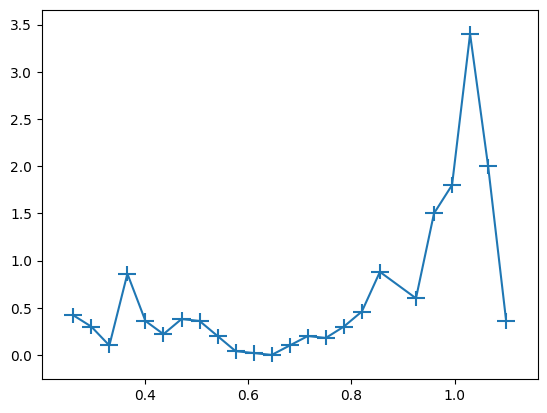

In [17]:
theta_scan = np.array(np.radians([15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,53,55,57,59,61,63]))
M_scan = np.array([0.42, 0.3, 0.1, 0.86, 0.36, 0.22, 0.38, 0.36, 0.2, \
            0.04, 0.02, 0, 0.1, 0.2, 0.18, 0.3, 0.46, 0.88, 0.60, 1.5, 1.8, 3.4, 2.0, 0.36])
err_theta = np.radians(1)
err_M_scan = np.array([0.08] * len(M_scan))

plt.errorbar(theta_scan, M_scan, err_M_scan, err_theta)
plt.show()

### Primo tentativo: circa 40°, n stimato = 2
Dopo lo scan non possiamo più pensare sia un massimo, ma non buttiamo i dati

In [18]:
thetas = np.radians([39, 40, 41, 42, 43, 44])
M = [0.12, 0.24, 0.16, 0.5, 0.34, 0.34 ] #x1 mA
err_M = np.array([0.08] * len(M))


def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas, M, err_M, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.show()

theta_max = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(theta_max)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.845 (χ²/ndof = 2.3)      │              Nfcn = 78               │
│ EDM = 3.51e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -50    │    40     │            │            │         │         │       │
│ 1 │ b    │    80     │    50     │            │            │         │         │       │
│ 2 │ c    │    -30    │    19     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.37e+03   -2.0e3    0.7e3 │
│ b │   -2.0e3 2.88e+03   -1.0e3 │
│ c │    0.7e3   -1.0e3      377 │
└───┴────────────────────────────┘

(0.7506739064272445, 0.01174839239955164)


### Secondo tentativo: circa 20°, n stimato = 1


In [19]:
thetas2 = np.radians([21, 22, 23, 24, 26])
M2 = [0.3, 0.38*3, 0.38*3, 0.8*3, 0.14] #ma con fattore specificato
err_M2 = np.array([0.08, 0.08*3, 0.08*3, 0.08*3, 0.08])


def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas2, M2, err_M2, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.show()

theta_max2 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(np.degrees(theta_max2))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.75 (χ²/ndof = 7.4)      │              Nfcn = 92               │
│ EDM = 1.41e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -830    │    90     │            │            │         │         │       │
│ 1 │ b    │    680    │    70     │            │            │         │         │       │
│ 2 │ c    │   -137    │    15     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 8.08e+03     -7e3   1.35e3 │
│ b │     -7e3 5.45e+03  -1.11e3 │
│ c │   1.35e3  -1.11e3      225 │
└───┴────────────────────────────┘

[2.34510569e+01 2.80822469e-03]


### Terzo tentativo: circa 60°, n stimato = 2

In [20]:
thetas3 = np.array(np.radians([53,55, 57, 58, 59, 60, 61, 62, 63, 64]))
M3 = np.array([0.6, 1.5, 1.8, 2.64, 3.4, 2.04, 2.0,  0.2, 0.36, 0.14])
err_M3 = np.array([0.24] * len(M3))


def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas3, M3, err_M3, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.show()

theta_max3 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(np.degrees(theta_max3))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 49.17 (χ²/ndof = 7.0)      │              Nfcn = 93               │
│ EDM = 8.17e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -256    │    20     │            │            │         │         │       │
│ 1 │ b    │    520    │    40     │            │            │         │         │       │
│ 2 │ c    │   -260    │    21     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │      408   -0.8e3    0.4e3 │
│ b │   -0.8e3 1.71e+03   -0.9e3 │
│ c │    0.4e3   -0.9e3      446 │
└───┴────────────────────────────┘

[5.80383258e+01 2.71923484e-02]


### Calcolo di d con fit dai tentativi (failed)

Evito il calcolo del primo tentativo tanto non è massimo

In [21]:
d2 = value_and_covariance("(1 * 2.85) / (2 * sin(t) )", t = (theta_max2[0], theta_max2[1]))
d3 = value_and_covariance("(2 * 2.85) / (2 * sin(t) )", t = (theta_max3[0], theta_max3[1]))
print("d2: " + str(d2))
print("d3: " + str(d3))

d2: (3.5807119152194673, 0.003339449105139494)
d3: (3.3592550914648336, 0.002084947930393363)


### Calcolo di d guardando i massimi trovati dall'unione di tutti i dati (failed)

In [22]:
d2 = (1 * 2.85) / (2 * np.sin(np.radians(24)))
d3 = (2 * 2.85) / (2 * np.sin(np.radians(59)))

err_d2 = np.abs((1 * 2.85/ 2) * np.cos(24) / (np.sin(24)**2) * np.radians(1))
err_d3 = np.abs((2 * 2.85/ 2) * np.cos(59) / (np.sin(59)**2) * np.radians(1))


print("d2: " + str(d2) + "    err: " + str(err_d2))
print("d3: " + str(d3) + "    err: " + str(err_d3))

d2: 3.5034955031932897    err: 0.012864393904540748
d3: 3.324905182063692    err: 0.0946019839211598


### Calcol di d da slicing di tutti i dati presi (work in progress)

In [25]:
from scipy.stats import chi2
def pvalue ( my_minuit ):
    '''ritorna il p value associata ad una stima nel caso i residui 
    siano distribuiti secondo una distribuzione normale'''
    Q2 = my_minuit.fval
    gdl = my_minuit.ndof
    return 1 - chi2.cdf(Q2, df = gdl)

n = 1

In [27]:
theta_1 = np.array(theta_sorted[1:13])
M_1 = np.array(M_sorted[1:13])

theta_1t = np.delete(theta_1, 7)
M_1t = np.delete(M_1, 7)

err_M = np.array([0.24] * len(M_1t))

def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(theta_1t, M_1t, err_M, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
print(pvalue(m))

theta_max1 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(np.degrees(theta_max1))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.59 (χ²/ndof = 2.6)      │              Nfcn = 84               │
│ EDM = 5.56e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -39    │    19     │            │            │         │         │       │
│ 1 │ b    │    31     │    15     │            │            │         │         │       │
│ 2 │ c    │   -5.5    │    3.0    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │     347 -0.28e3      55 │
│ b │ -0.28e3     226     -45 │
│ c │      55     -45    8.98 │
└───┴─────────────────────────┘

0.008333988692045935
[22.69636013  0.25307701]


n = 2

In [28]:
theta_2 = np.array(theta_sorted[29:42])
M_2 = np.array(M_sorted[29:42])

theta_2t = np.delete(theta_2, [2,3,5,6])
M_2t = np.delete(M_2, [2,3,5,6])

err_M = np.array([0.24] * len(M_2t))

def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(theta_2t, M_2t, err_M, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
print(pvalue(m))

theta_max1 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(np.degrees(theta_max1))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.89 (χ²/ndof = 3.1)      │              Nfcn = 93               │
│ EDM = 1.72e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -285    │    29     │            │            │         │         │       │
│ 1 │ b    │    580    │    60     │            │            │         │         │       │
│ 2 │ c    │   -288    │    30     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │     848  -1.7e3   0.9e3 │
│ b │  -1.7e3 3.5e+03  -1.8e3 │
│ c │   0.9e3  -1.8e3     896 │
└───┴─────────────────────────┘

0.004358098376795683
[5.78710302e+01 3.13317402e-02]
